In [4]:
import numpy as np
import matplotlib.pyplot as plt
from backtester.backtester import Backtester
from backtester.strategy import Strategy
from backtester.historical_data import HistoricalData
import talib as ta

ModuleNotFoundError: No module named 'backtester'

short period = 15m

CRYPTO:
stop_loss_multiplier = 10
take_profit_multiplier = 20
longer_ema_offset = -8

FOREX:
stop_loss_multiplier = 2
take_profit_multiplier = 8
longer_ema_offset = -4

In [1]:
asset = "EURUSD"
long_start = '2024-05-21'
long_end = '2024-08-22'
long_interval = '1h'
short_start = '2024-06-26'
short_end = '2024-08-22'
short_interval = '15m'

In [2]:
short_period = 12
long_period = 26
longer_period = 200
trend_period = 100
atr_period = 14
commission_percentage = 0.001
stop_loss_multiplier = 10
take_profit_multiplier = 40
amount_invested = 1000
leverage = 1
longer_ema_offset = -8      # -8 for crypto and 0 for forex
hourly_date_offset = 0    # 0 for forex/crypto and 30 for stocks

In [3]:
short_historical_data = HistoricalData(asset, short_start, short_end, short_interval)
short_data = short_historical_data.get_data()
# short_historical_data.plot_data()

NameError: name 'HistoricalData' is not defined

In [440]:
long_historical_data = HistoricalData(asset, long_start, long_end, long_interval)
long_data = long_historical_data.get_data()
# long_historical_data.plot_data()

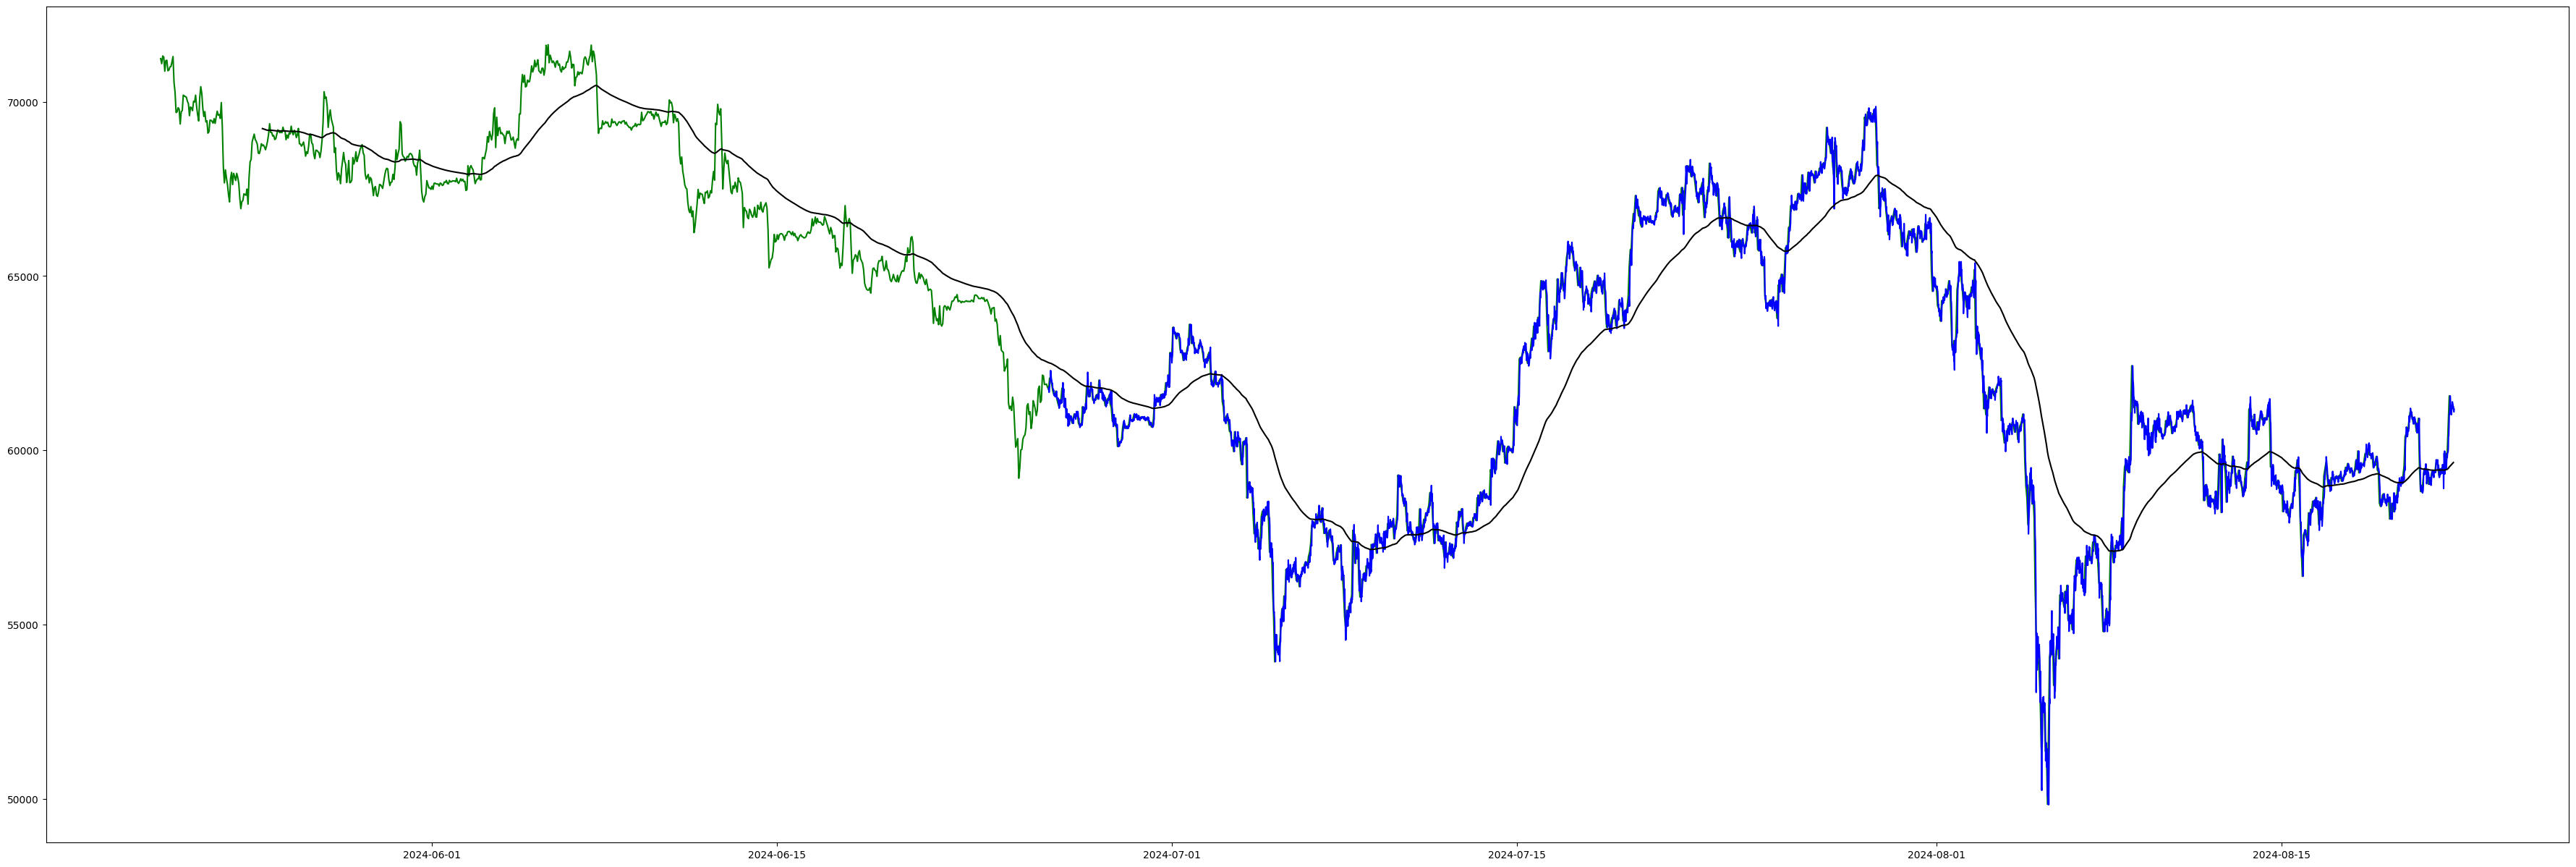

In [441]:
from datetime import timedelta


long_data['EMA'] = ta.EMA(long_data['Close'], trend_period)
figure, axis = plt.subplots(1, figsize=(45, 15))
axis.plot(long_data.index, long_data.Close, color='green')
axis.plot(short_data.index, short_data.Close, color='blue')
axis.plot(long_data.index, long_data['EMA'], color='black')

In [442]:
class EMACrossoverShortStrategy(Strategy):
    def __init__(self, data, long_data):
        super().__init__(data)
        self.long_data = long_data
        self.long_data['EMA'] = ta.EMA(self.long_data['Close'], trend_period)
        self.data['Hourly Date'] = self.data.index.floor('h') + timedelta(minutes=hourly_date_offset)
        self.data['Short EMA'] = ta.EMA(self.data['Close'], short_period)
        self.data['Long EMA'] = ta.EMA(self.data['Close'], long_period)
        self.data['ATR'] = ta.ATR(self.data.High, self.data.Low, self.data.Close, atr_period) # ATR is used for setting stop loss
        self.data['Longer EMA'] = ta.SMA(self.data['Close'], longer_period) + (longer_ema_offset*self.data['ATR'])
        self.data['Previous Short EMA'] = self.data['Short EMA'].shift()
        self.data['Previous Long EMA'] = self.data['Long EMA'].shift()
        self.data['Previous Longer EMA'] = self.data['Longer EMA'].shift()
        self.data['Previous Close'] = self.data['Close'].shift()
        self.data = self.data.dropna()
             
    def implement(self):
        self.data['Signal'] = 0
        self.data['Position'] = 0
        position_checker = ((self.data['Short EMA'] < self.data['Long EMA']) & \
            (self.data['Previous Short EMA'] >= self.data['Previous Long EMA']) & \
            (self.data['Close'] < self.data['Longer EMA']))
        self.data['Position'] = np.where(position_checker, -1,
                                np.where(((self.data['Short EMA'] > self.data['Long EMA']) & (self.data['Previous Short EMA'] <= self.data['Previous Long EMA'])), 1, 0))

        for i in self.data.index:
            if self.position == 'close':
                if (self.data.at[i, 'Position'] == -1) and (self.data.at[i, 'Close'] < self.long_data.at[self.data.at[i, 'Hourly Date'], 'EMA']):
                    sell_price = self.data['Close'][i]
                    stop_loss = sell_price + (stop_loss_multiplier * self.data.at[i, 'ATR'])
                    take_profit = sell_price - (take_profit_multiplier * self.data.at[i, 'ATR'])
                    self.position = 'sell'
                    self.sell_trade(i, stop_loss=stop_loss, take_profit=take_profit)
                    self.data.at[i, 'Signal'] = -1
            else:            
                if (self.data.at[i, 'Close'] >= self.stop_loss) | (self.data.at[i, 'Close'] <= self.take_profit):
                    self.close_trade(i)
                    self.data.at[i, 'Signal'] = 0
                    self.position = 'close'
                else:
                    self.data.at[i, 'Signal'] = -1

    def plot_indicators(self):
        _, axis = plt.subplots(2, sharex=False, figsize=(45, 25))
        axis[0].set_title("Close Price Series with Crossovers") 
        axis[0].plot(self.data.index, self.data['Short EMA'], color='blue')
        axis[0].plot(self.data.index, self.data['Long EMA'], color='green')
        axis[0].plot(self.data.index, self.data['Longer EMA'], color='black')
        axis[0].grid()
        axis[1].set_title("Trend EMA") 
        axis[1].plot(long_data.index, long_data['EMA'], color='black')
        axis[1].plot(long_data.index, long_data['Close'], color='green')
        axis[1].plot(self.data.index, self.data['Close'], color='red')
        axis[1].grid()
        plt.show()

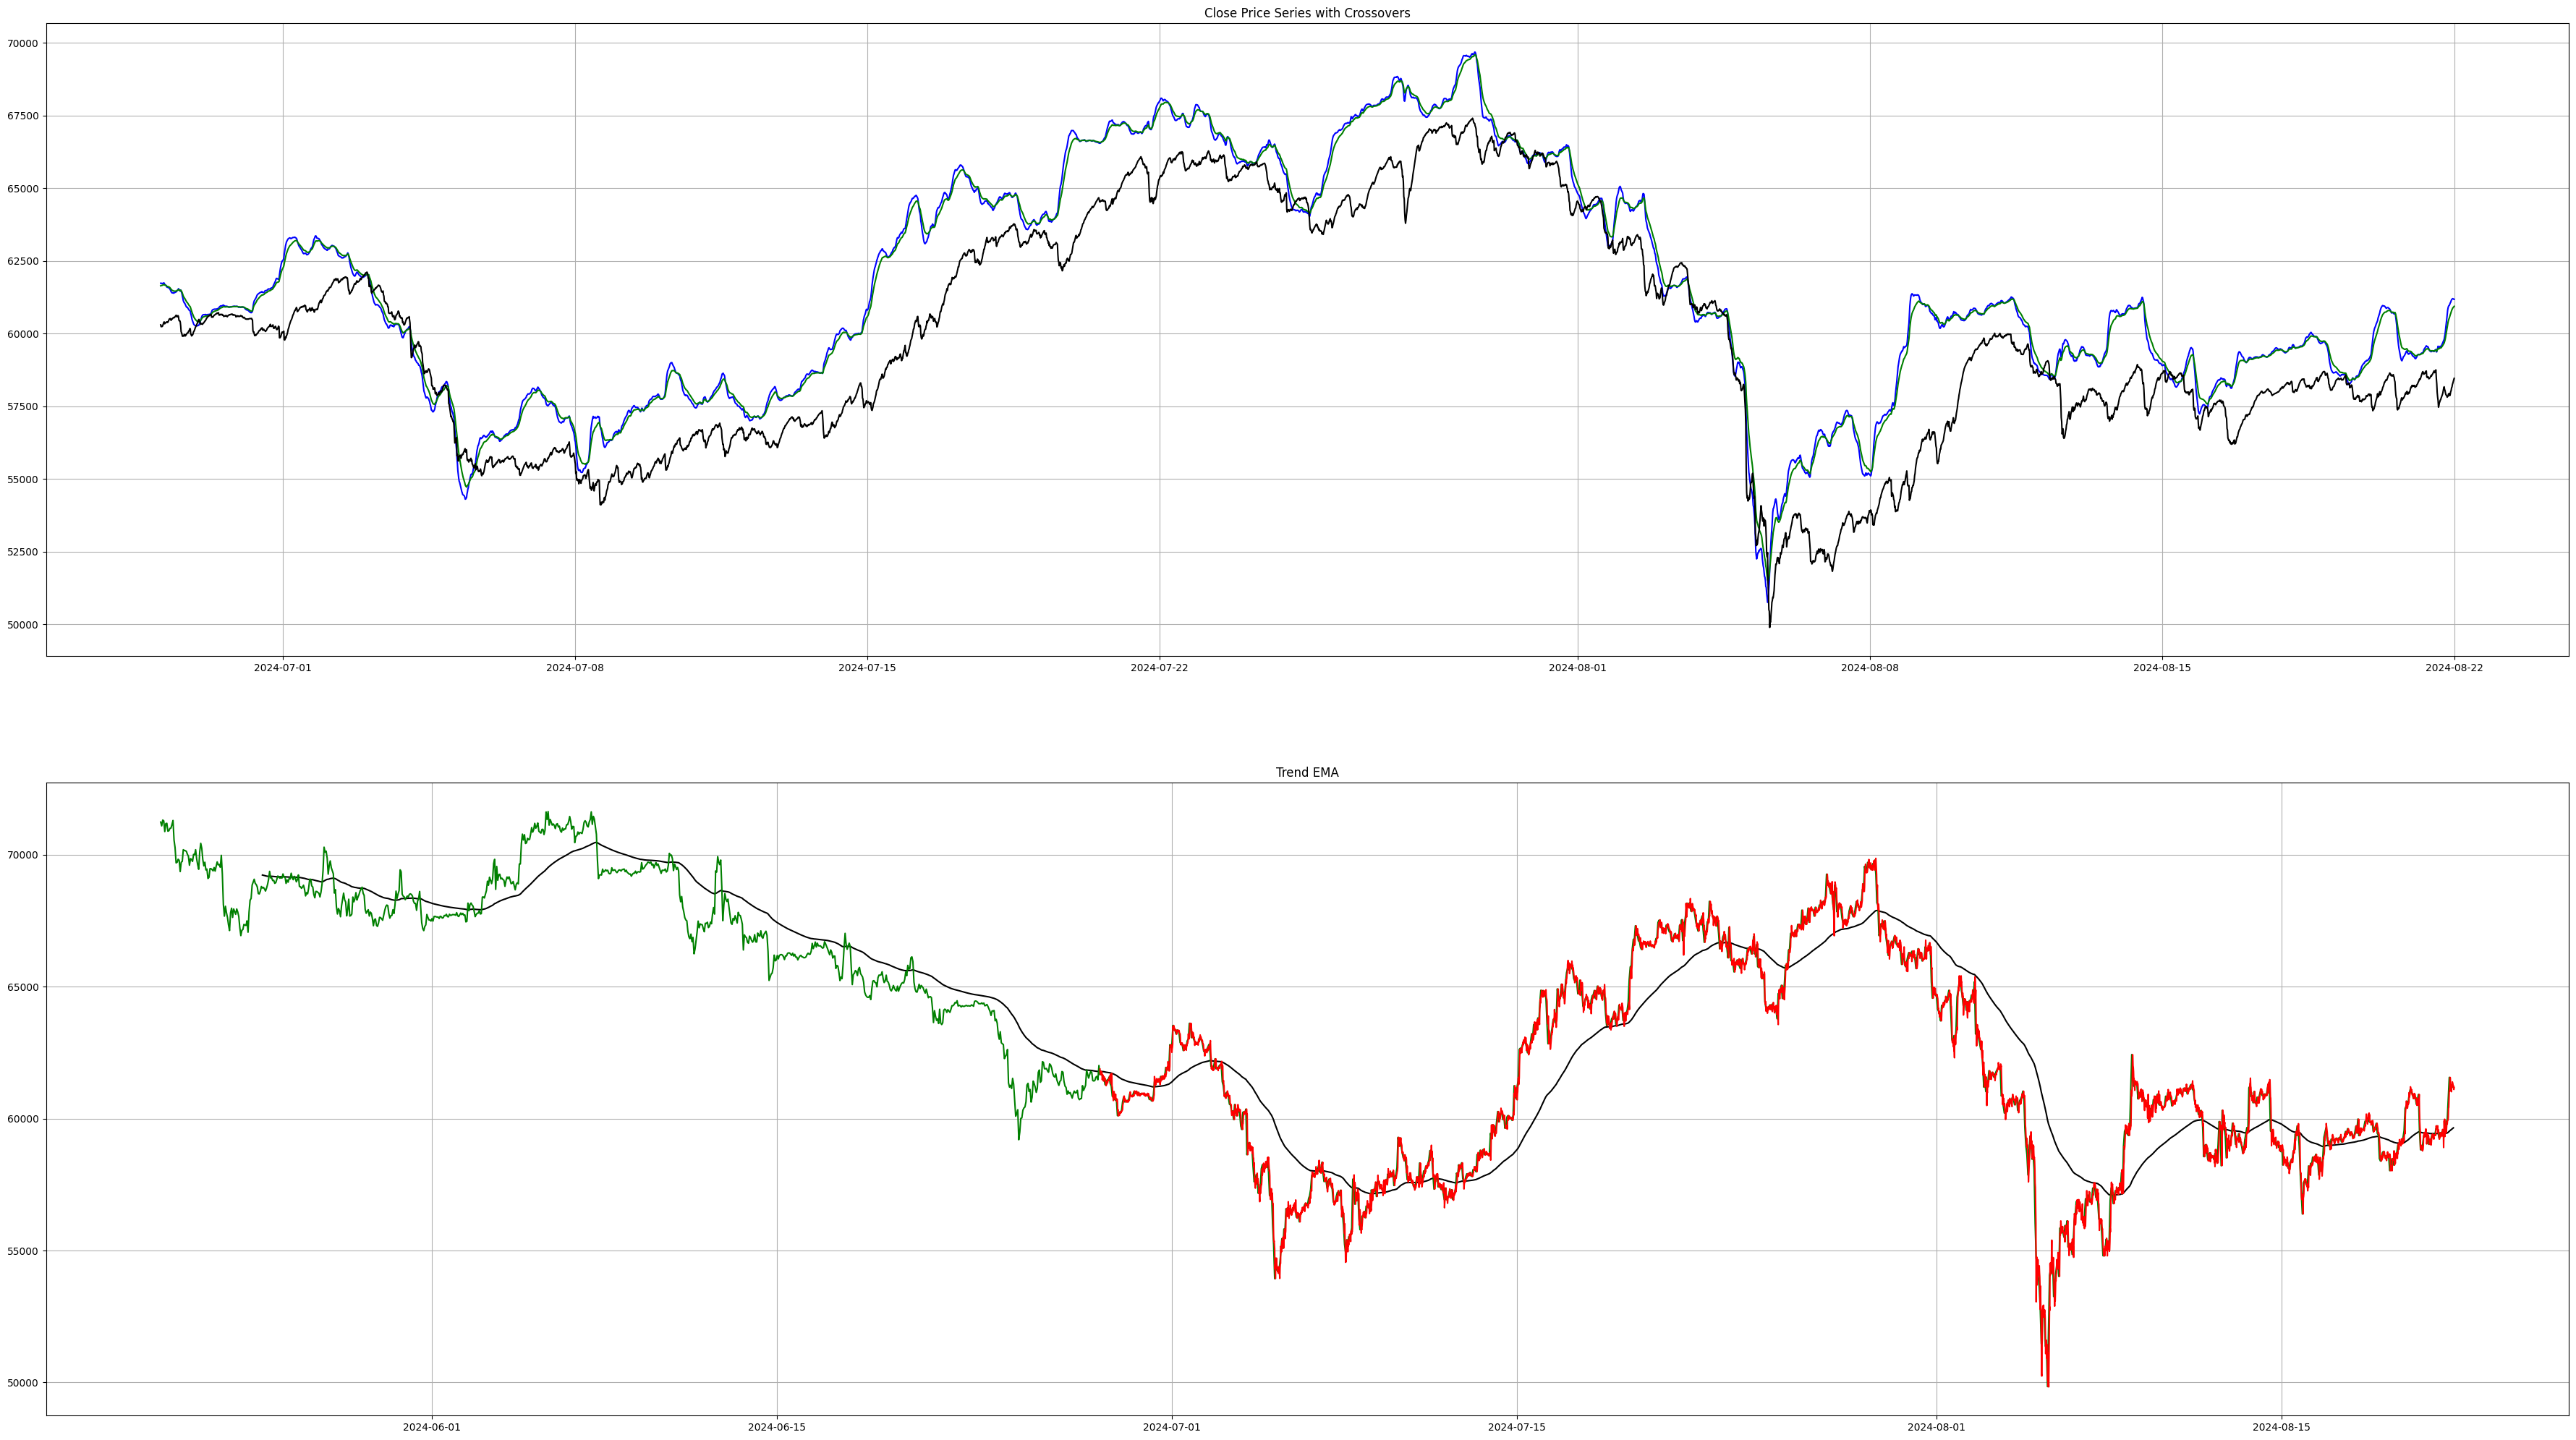

In [443]:
emaCrossover = EMACrossoverShortStrategy(data=short_data, long_data=long_data)
emaCrossover.plot_indicators()

/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_75831/3341609982.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Signal'] = 0
/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_75831/3341609982.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'] = 0
/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_75831/3341609982.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

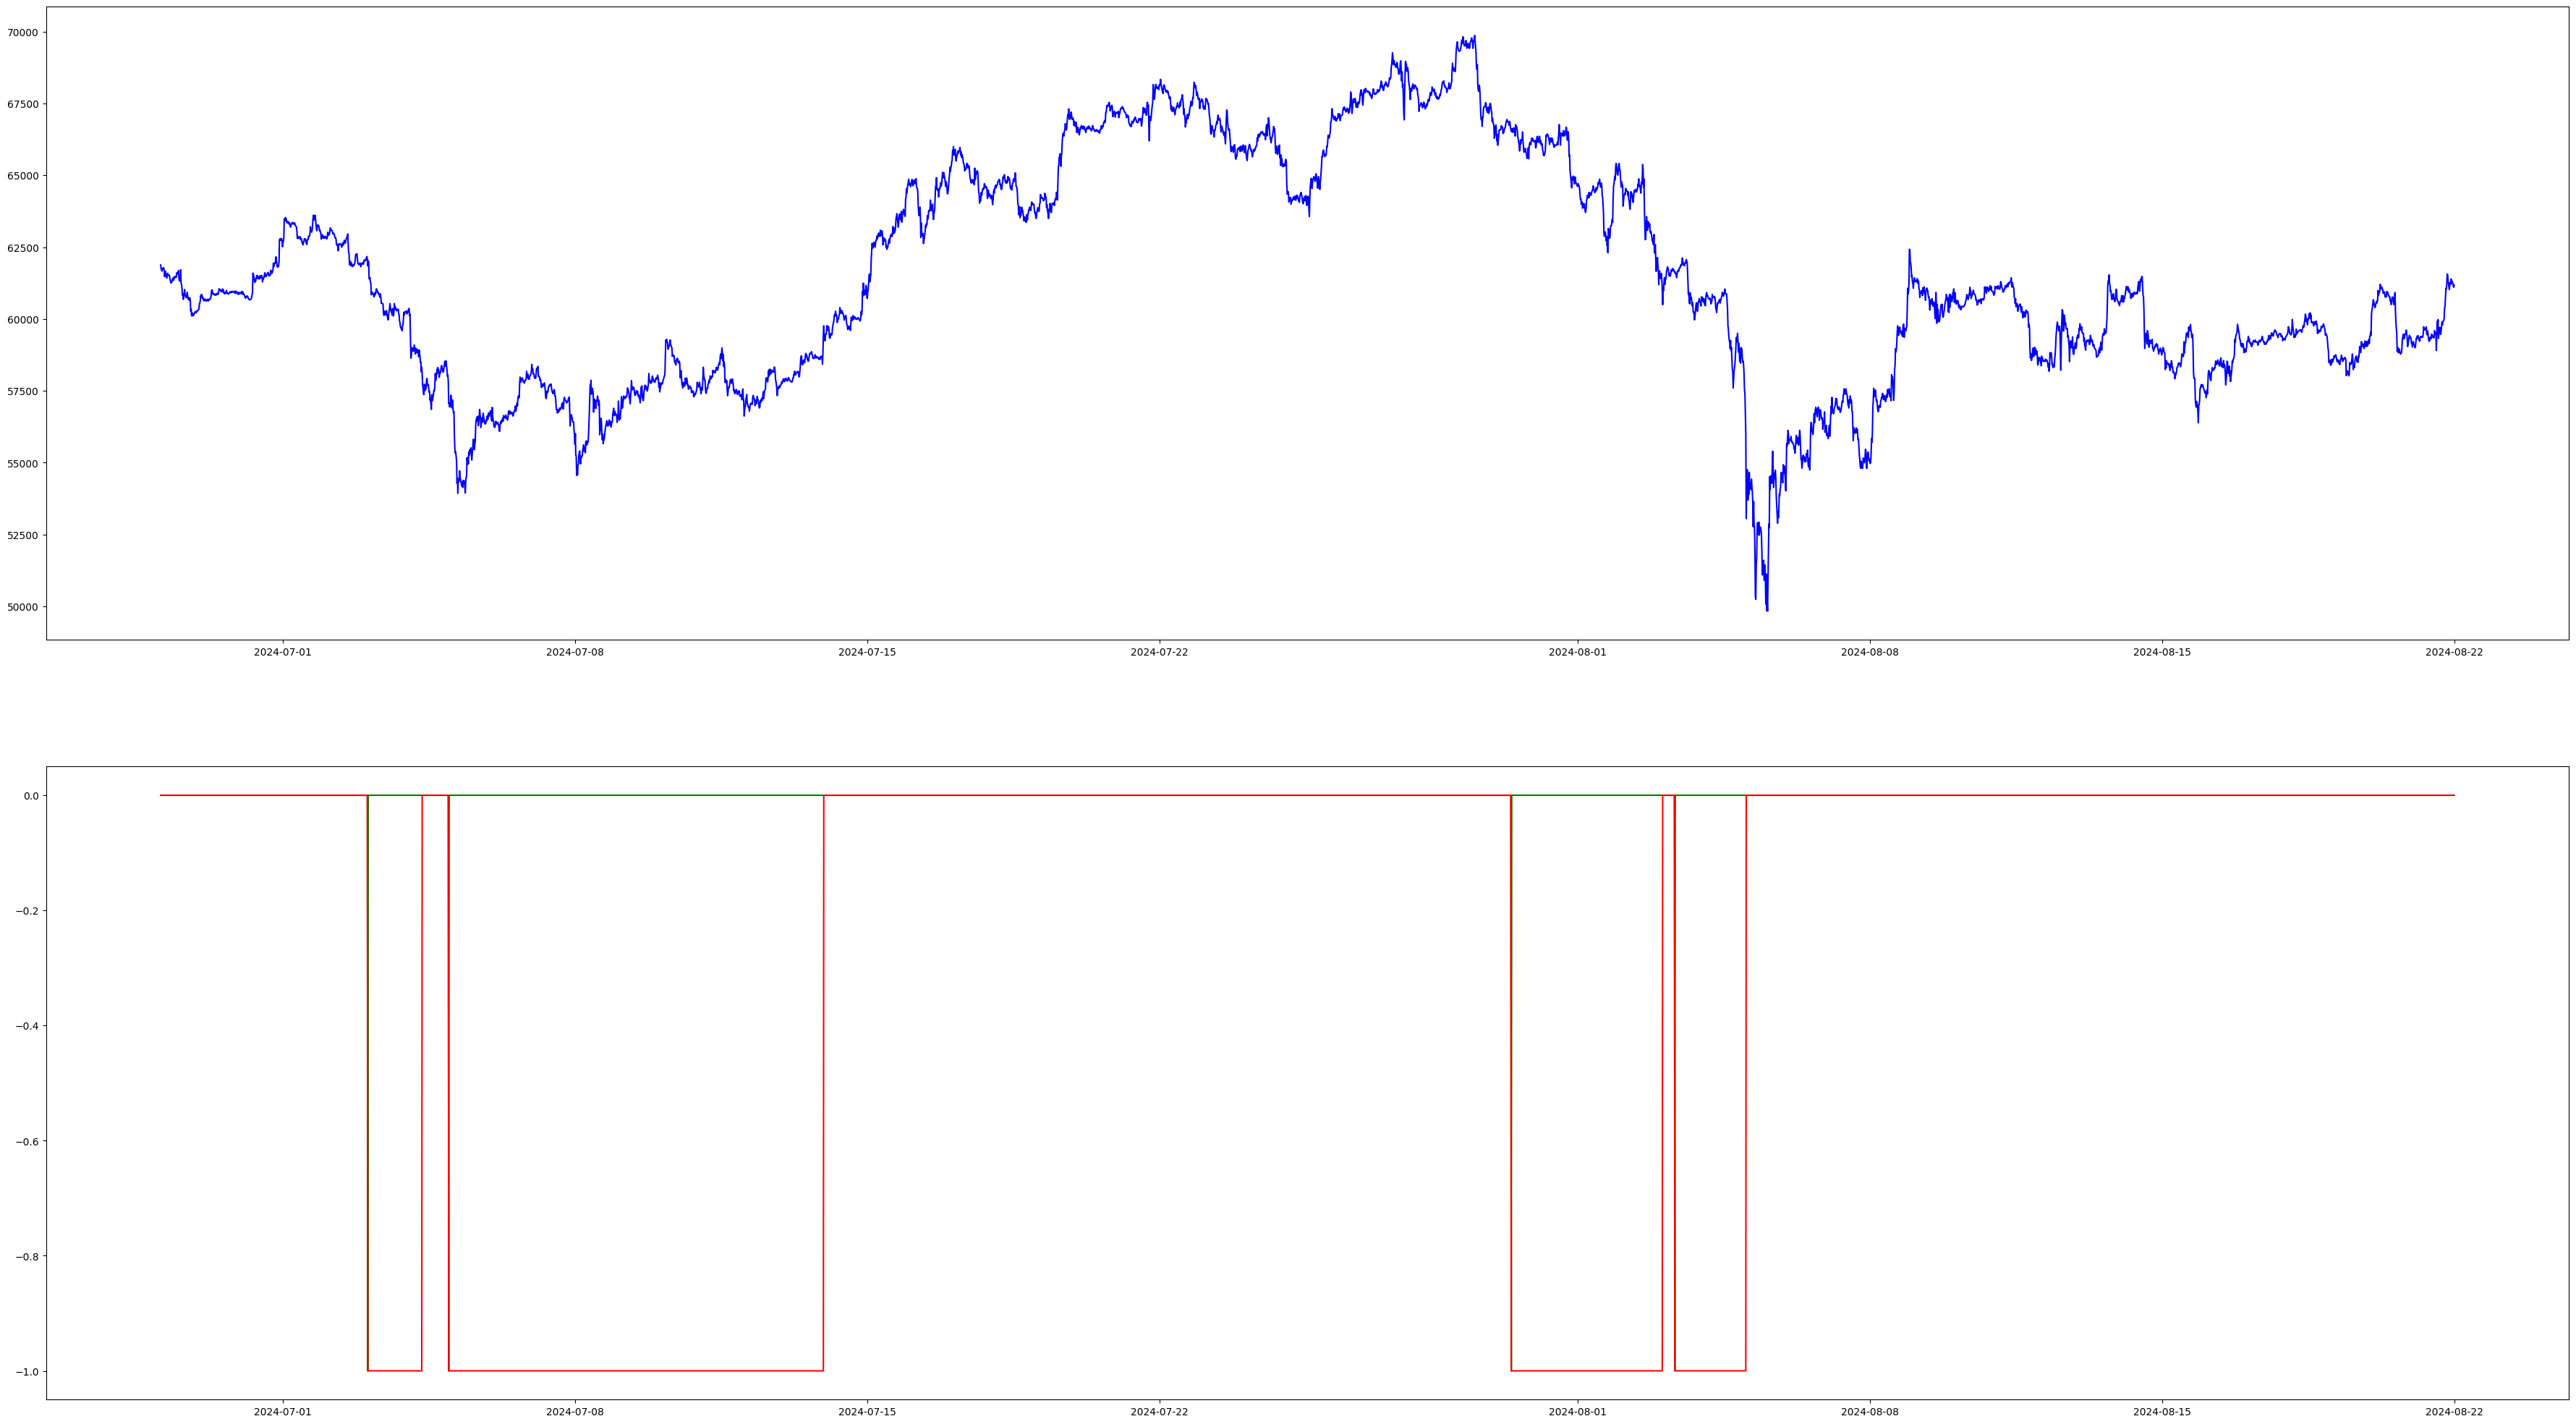

In [444]:
emaCrossover.implement()
emaCrossover.plot_positions()

/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '998.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.at[i, 'Cumulative Strategy Returns'] = cash


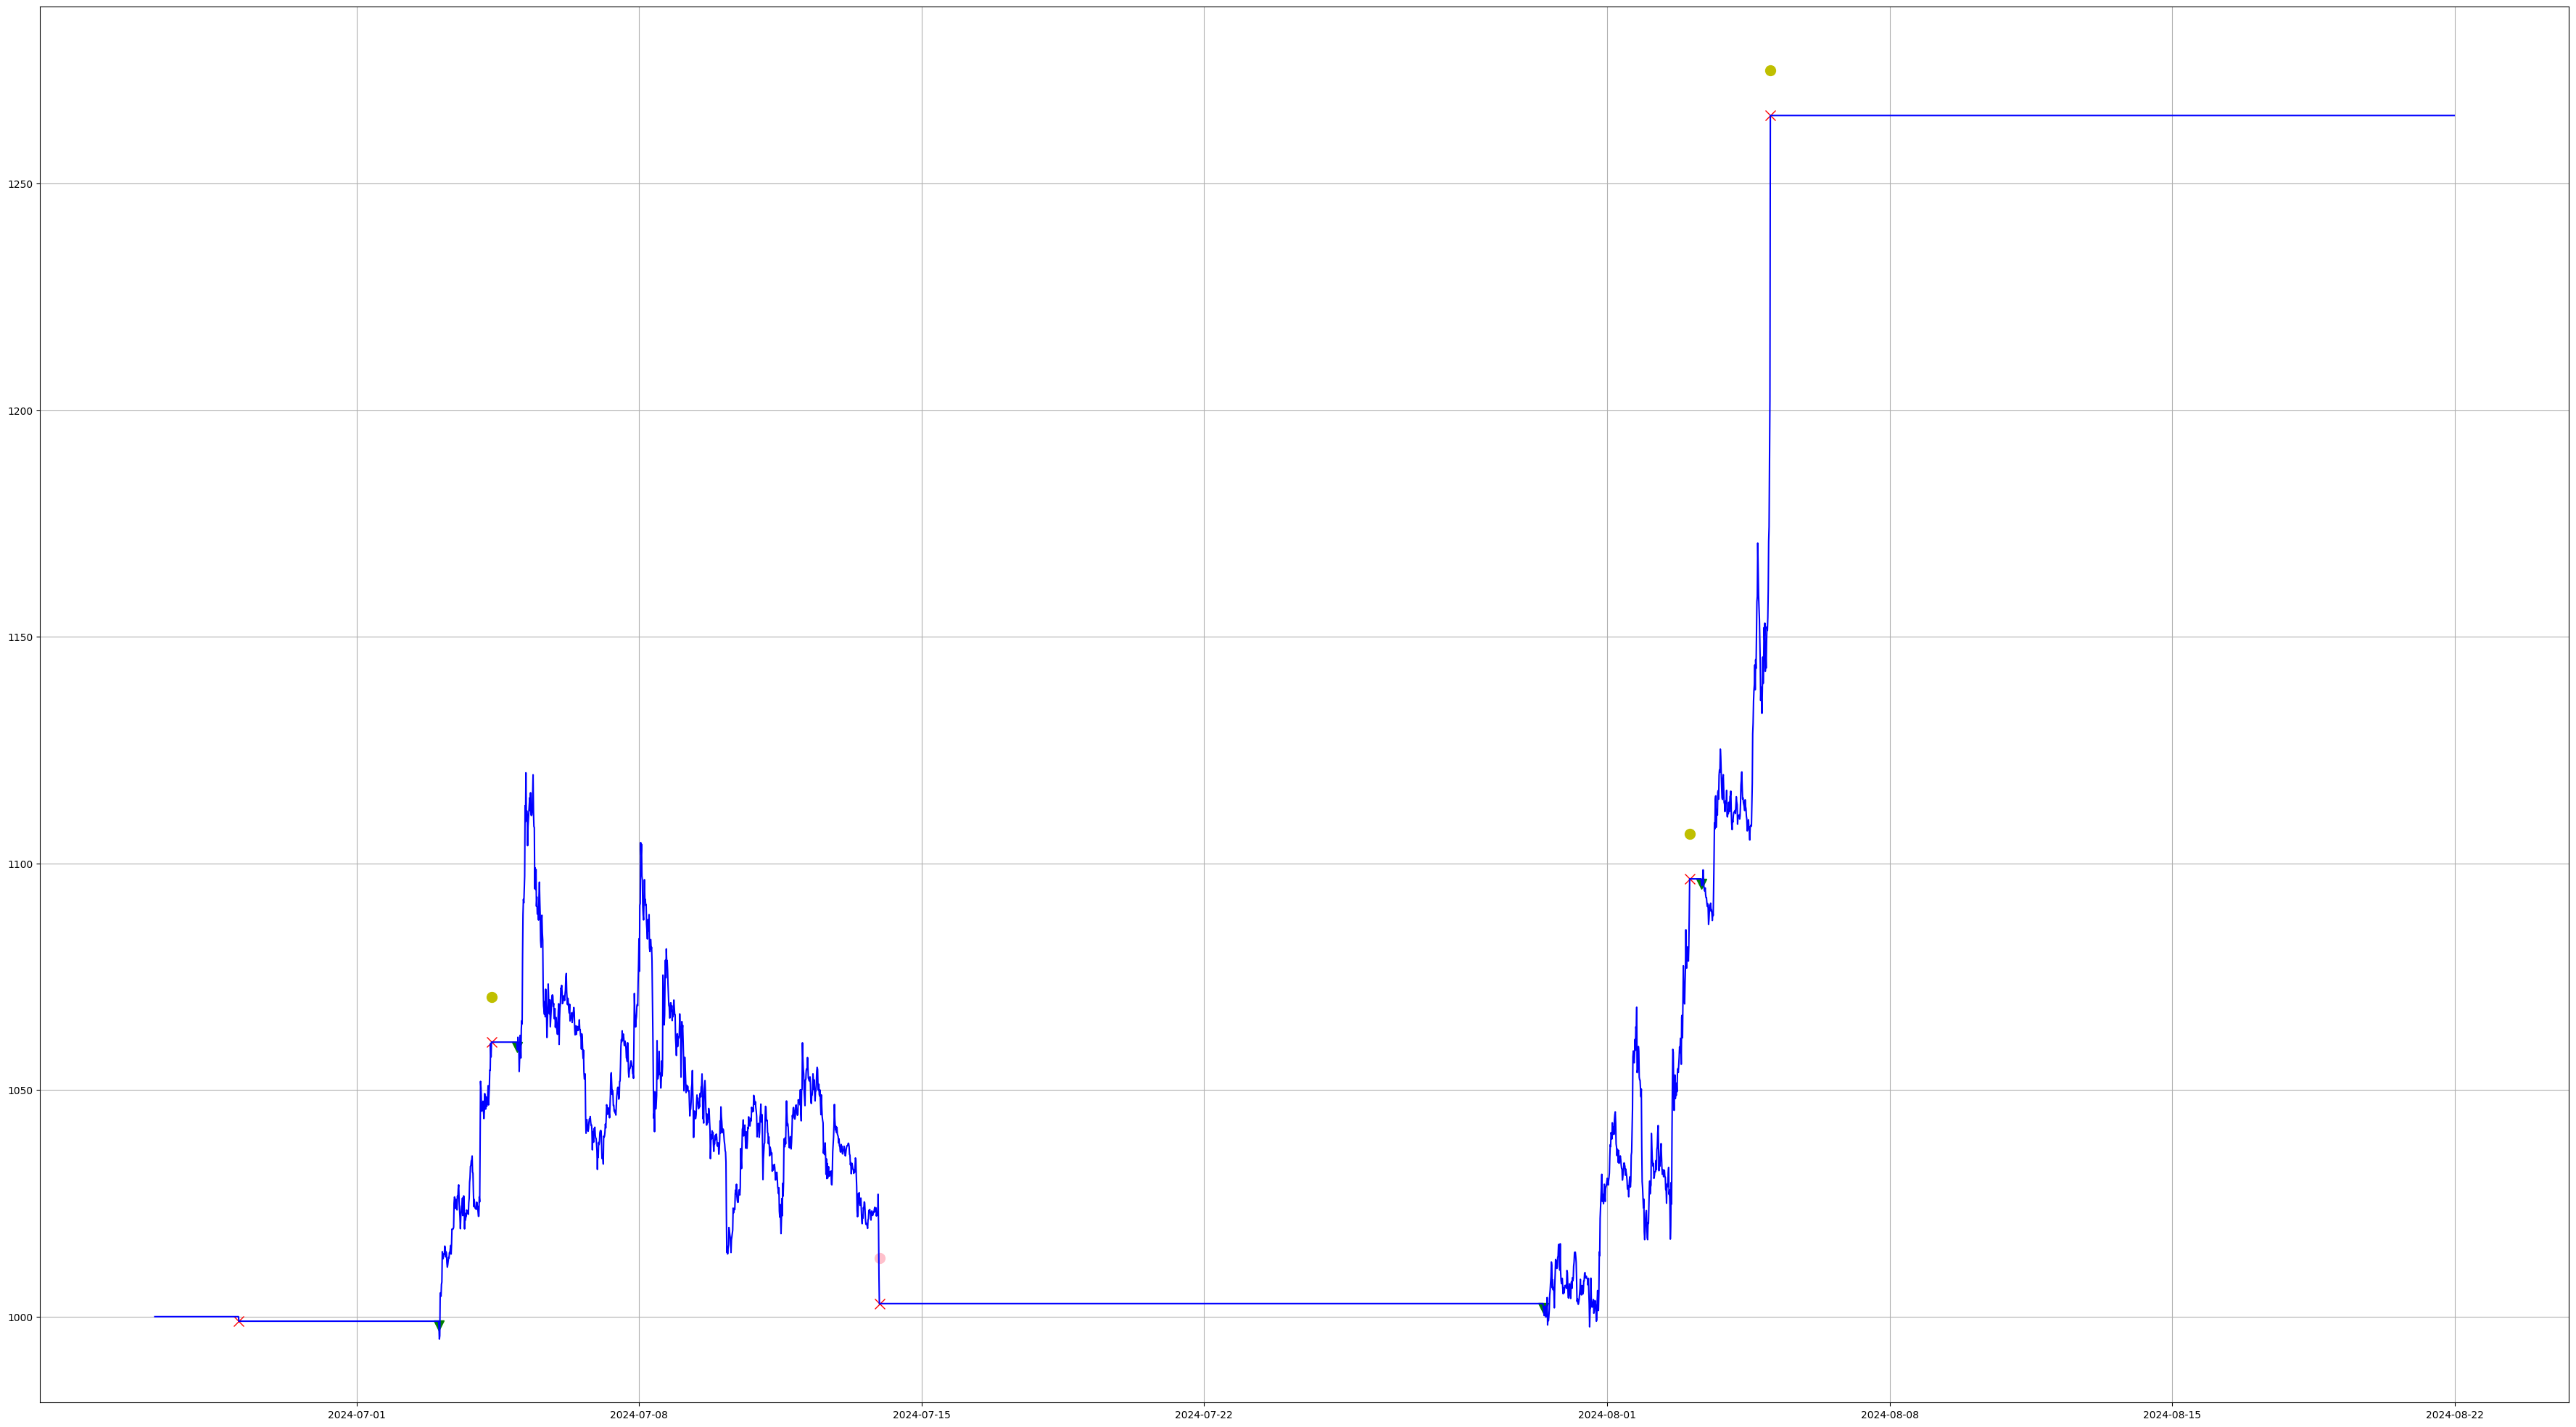

In [445]:
backtester = Backtester(emaCrossover, short_data, trade_commission=commission_percentage, amount_invested=amount_invested, leverage_ratio=leverage)
backtester.backtest()
backtester.plot_backtest()

In [446]:
backtester.get_metrics()

Final value:  1264.9842797493518
P&L:  264.9842797493518
Returns %:  26.49842797493518
Number of trades:  4
Loss trades %:  25.0
Profit trades %:  75.0
Annual Sharpe ratio:  3.9657238398632617
Max profit %:  26.49842797493518
Max loss %:  -0.49522812771012925


/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Final value: ', self.data['Cumulative Strategy Returns'][-1])
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('P&L: ', (self.data['Cumulative Strategy Returns'][-1] - (self.leverage_ratio*self.amount_invested)))
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys